# Assignment #1: Sequence Labeling
## Natural Language Processing
### Alberto Luise, Angelo Quarta, Edoardo Fusa

In [2]:
import pathlib
import pandas as pd
import numpy as np
import urllib
import zipfile
import os
import collections
import string
import matplotlib.pyplot as plt

The first step is obviously to download and prepare the dataset; we'll first verify if we have already downloaded the files, and if not we'll request them and unzip them. After that, we'll build a Dataframe containing all available samples, dividing them in Training, validation & Test sets.

In [3]:
Data_url = "https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/packages/corpora/dependency_treebank.zip"
Dataset = Data_url.split("/")[-1].split(".")[0]
print(f"Download folder: {pathlib.Path.cwd()}")
dataset_folder = pathlib.Path.cwd().joinpath("Datasets")

if not dataset_folder.exists():
    dataset_folder.mkdir(parents=True)
if not dataset_folder.joinpath(Dataset).exists():
    filename = dataset_folder.joinpath("Assignment_Dataset.zip")
    urllib.request.urlretrieve(url=Data_url, filename=filename)
    print("Download finished! Extracting...")
    with zipfile.ZipFile(filename, 'r') as zip_ref:
        zip_ref.extractall(dataset_folder)

Download folder: c:\Users\Alber\Documents\Notebooks\Assignment_1


In [4]:
rows = []
raw_data_folder = dataset_folder.joinpath(Dataset)
for r, set in [(range(1, 101), "train"), (range(101, 151), "val"), (range(151, 200), "test")]:
    for i in r:
        f = open(raw_data_folder.joinpath("wsj_" + str(i).zfill(4) + ".dp"),  "r")
        for line in f.readlines():
            if line != "\n":
                (word, pos, _) = line.split()
                dataframe_row = {
                            "Sentence_ID": i,
                            "set": set,
                            "text": word,
                            "POS": pos
                        }
                rows.append(dataframe_row)
        f.close()

In [5]:
df_folder = dataset_folder.joinpath("Dataframe")
if not df_folder.exists():
    df_folder.mkdir(parents=True)
df = pd.DataFrame(rows)
df = df[["Sentence_ID", 
         "set",
         "text",
         "POS"]]
df_path = df_folder.joinpath(Dataset).with_name(Dataset + ".pkl")
df.to_pickle(df_path)

In [6]:
print("Complete Dataframe:")
print(df)
print()

print("Distribution of POS: ")
print(df['POS'].value_counts())
print()

print("Distribution of splits: ")
print(df['set'].value_counts())
print()

Complete Dataframe:
       Sentence_ID    set     text  POS
0                1  train   Pierre  NNP
1                1  train   Vinken  NNP
2                1  train        ,    ,
3                1  train       61   CD
4                1  train    years  NNS
...            ...    ...      ...  ...
94079          199   test  quarter   NN
94080          199   test       of   IN
94081          199   test     next   JJ
94082          199   test     year   NN
94083          199   test        .    .

[94084 rows x 4 columns]

Distribution of POS: 
POS
NN       13166
IN        9857
NNP       9410
DT        8165
NNS       6047
JJ        5834
,         4886
.         3874
CD        3546
VBD       3043
RB        2822
VB        2554
CC        2265
TO        2179
VBN       2134
VBZ       2125
PRP       1716
VBG       1460
VBP       1321
MD         927
POS        824
PRP$       766
$          724
``         712
''         694
:          563
WDT        445
JJR        381
NNPS       244
WP         2

#### The POS column has some values (FW, UH, SYM) that are extremely rare, appearing only a single-digit number of times in 94k examples. These could reveal to be really hard to learn & recognize, we'll see if some data augmentation is in order.

Since our machine only understands numbers, we have to embed the words before using them as input data. We'll use GloVe Embedding (Global Vectors), an unsupervised algorithm based on co-occurrence statistics from a specific corpus.

### Step 1: Creating a Vocabulary

In [7]:
def exclude_symbols(s):
   return not all(i in string.punctuation for i in s)

df['text'] = df['text'].str.lower()
df['text'] = df['text'].str.strip()
mask = df['text'].apply(exclude_symbols)
df = df[mask]
# ...does this go against "do not delete any tokens"?

In [8]:
def build_vocabulary(df: pd.DataFrame):
    """
    Function defining a vocabulary, returning both an 'Index-to-Word' version and a 'Word-to-Index' version.
    Done temporarily to test everything, could be improved or cleaned up.
    """
    Index_to_Word = collections.OrderedDict()
    Word_to_Index = collections.OrderedDict()
    
    idx = 0
    for token in df.text.values:
        if token not in Word_to_Index:
            Word_to_Index[token] = idx
            Index_to_Word[idx] = token
            idx += 1

    return Index_to_Word, Word_to_Index


idx_to_word, word_to_idx = build_vocabulary(df[df['set'] == 'train'])
print(f'[Debug] Index -> Word vocabulary size: {len(idx_to_word)}')
print(f'[Debug] Word -> Index vocabulary size: {len(word_to_idx)}')
print(f'[Debug] Some words: {[(idx_to_word[idx], idx) for idx in np.arange(10)]}')

[Debug] Index -> Word vocabulary size: 7386
[Debug] Word -> Index vocabulary size: 7386
[Debug] Some words: [('pierre', 0), ('vinken', 1), ('61', 2), ('years', 3), ('old', 4), ('will', 5), ('join', 6), ('the', 7), ('board', 8), ('as', 9)]


In [9]:
# Optional: save the vocabulary to a JSON for manual checking
SAVE_VOC = True

if SAVE_VOC:
    import simplejson as sj

    vocab_path = pathlib.Path.cwd().joinpath('Datasets', 'Vocabulary.json')

    print(f"Saving vocabulary to {vocab_path}")
    with vocab_path.open(mode='w') as f:
        sj.dump(word_to_idx, f, indent=4)
    print("Saving completed!")

Saving vocabulary to c:\Users\Alber\Documents\Notebooks\Assignment_1\Datasets\Vocabulary.json
Saving completed!


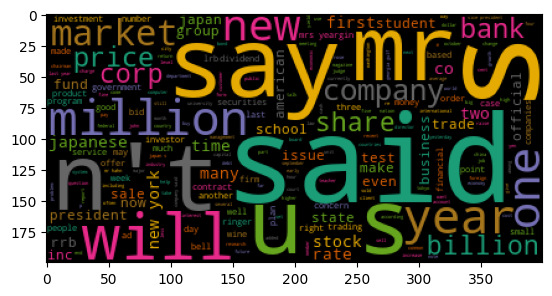

In [10]:
# A bit of visualization

from wordcloud import WordCloud

q_S = ' '.join(df[df['set']=='train']['text'])
wordcloud_S = WordCloud(max_font_size=None,scale = 1,colormap = 'Dark2').generate(q_S)
plt.imshow(wordcloud_S)

### Step 2: Applying Embeddings

In [11]:
df_seq = df[df['set']=='train'].groupby(['Sentence_ID'])['text'].apply(' '.join).reset_index()
df_seq['text'] = df_seq['text'].apply(str.split)
print(df_seq.head())
# Not really useful for now but I'm keeping it there

   Sentence_ID                                               text
0            1  [pierre, vinken, 61, years, old, will, join, t...
1            2  [rudolph, agnew, 55, years, old, and, former, ...
2            3  [a, form, of, asbestos, once, used, to, make, ...
3            4  [yields, on, money-market, mutual, funds, cont...
4            5  [j.p., bolduc, vice, chairman, of, w.r., grace...


In [24]:
from keras import preprocessing

tokenizer = preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(df[df['set']=='train']['text'])
sequences = tokenizer.texts_to_sequences(df[df['set']=='train']['text'])
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

glove_folder = pathlib.Path.cwd().joinpath("GloVe")
if not glove_folder.exists():
    glove_folder.mkdir(parents=True)
    filename_2 = glove_folder.joinpath("GloVe.zip")
    urllib.request.urlretrieve(url='http://nlp.stanford.edu/data/glove.6B.zip', filename=filename_2)
    print("Download finished! Extracting...")
    with zipfile.ZipFile(filename_2, 'r') as zip_ref:
        zip_ref.extractall(glove_folder)
  
# vocab: 'the': 1, mapping of words with integers in seq. 1,2,3.. (0 is reserved)
# embedding: 1->dense vector 
def embedding_for_vocab(filepath, word_index, 
                        embedding_dim): 
    vocab_size = len(word_index) + 1
    # Adding again 1 because of reserved 0 index 

    embedding_matrix_vocab = np.zeros((vocab_size, embedding_dim)) 
    with open(filepath, encoding="utf8") as f: 
        for line in f: 
            word, *vector = line.split() 
            if word in word_index: 
                idx = word_index[word] 
                embedding_matrix_vocab[idx] = np.array( 
                    vector, dtype=np.float32)[:embedding_dim] 
    f.close()
  
    return embedding_matrix_vocab 
  
  
# matrix for vocab: word_index 
embedding_dim = 100
embedding_matrix_vocab = embedding_for_vocab( 
    glove_folder.joinpath(f'glove.6B.{embedding_dim}d.txt'), tokenizer.word_index, 
  embedding_dim) 
  
print("Dense vector for first word is =>", embedding_matrix_vocab[1]) 
print("Total tokens:", len(embedding_matrix_vocab)-1)

Found 6900 unique tokens.
Dense vector for first word is => [-0.038194   -0.24487001  0.72812003 -0.39961001  0.083172    0.043953
 -0.39140999  0.3344     -0.57545     0.087459    0.28786999 -0.06731
  0.30906001 -0.26383999 -0.13231    -0.20757     0.33395001 -0.33848
 -0.31742999 -0.48335999  0.1464     -0.37303999  0.34577     0.052041
  0.44946    -0.46970999  0.02628    -0.54154998 -0.15518001 -0.14106999
 -0.039722    0.28277001  0.14393     0.23464    -0.31020999  0.086173
  0.20397     0.52623999  0.17163999 -0.082378   -0.71787    -0.41531
  0.20334999 -0.12763     0.41367     0.55186999  0.57907999 -0.33476999
 -0.36559001 -0.54856998 -0.062892    0.26583999  0.30204999  0.99774998
 -0.80480999 -3.0243001   0.01254    -0.36941999  2.21670008  0.72201002
 -0.24978     0.92136002  0.034514    0.46744999  1.10790002 -0.19358
 -0.074575    0.23353    -0.052062   -0.22044     0.057162   -0.15806
 -0.30798    -0.41624999  0.37972     0.15006    -0.53211999 -0.20550001
 -1.25259995